# Homework 5 - Explore Wikipedia's hyperlinks network

## Data handling

In [1]:
import scripts.functionality as funcs
from scripts.graph import Graph, WeightedGraph
import pandas as pd
from collections import defaultdict
from scripts.graph import Graph

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
link_dict = funcs.read_graph()
link_df = funcs.read_graph(output='df')
link_dict = defaultdict(set, link_dict)

##### Read Data and save to json

In [4]:
pages_category = funcs.read_pages_category(filename='data/wiki-topcats-categories.txt')
funcs.write_json('data/page_category.json', pages_category)

In [5]:
name_page = funcs.read_name_page(filename='data/wiki-topcats-page-names.txt')
funcs.write_json('data/name_page.json', name_page)

##### Read data from json

In [6]:
# pages_category: Key is the category, and value is a list of integers which is associated to a set of articles
# name_page: Key is an integer that identifies the article. The value associated is the name of the article
pages_category = funcs.read_json('data/page_category.json')
name_page = funcs.read_json_int_key('data/name_page.json')

In [7]:
# Find articles assigned to multiple categories
article_category = funcs.revert_dict_list(pages_category)

In [8]:
# Randomly pick one category for each article
unique_category = funcs.uniformly_pick_article_category(article_category)

In [9]:
# Revert back from articles to categories
final_pages_category = funcs.revert_dict(unique_category)
funcs.write_json('data/final_pages_category.json', final_pages_category)

<br>

## Question 1 ~ Build the graph

As the first step, we build the graph leveraging the custom Graph class we defined:

In [11]:
g = Graph.from_dict(link_dict)

#### Is the graph directed?

The graph is directed, since each node corresponds to a Wikipedia article and each edge corresponds to a web link from an article to another.

#### How many articles are we considering?

The number of articles we are considering is equal to the number of nodes in the graph, that is the number of nodes which appear in our reduced dataset.

In [5]:
print(f'Number of articles:\t{g.n_vertices_}')

Number of articles:	98343


#### How many hyperlinks between pages exist?

The number of hyperlinks between the pages is equal to the number of edges in the graph.

In [6]:
print(f'Number of hyperlinks:\t{g.n_edges_}')

Number of hyperlinks:	483094


#### Compute the average number of links in an arbitrary page

The average number of links in an arbitrary page is simply equal to the fraction of the number of links over the number of vertices.

In [7]:
print(f'Average number of links in an arbitrary page:\t{round(g.n_edges_ / g.n_vertices_,3)}')

Average number of links in an arbitrary page:	4.912


#### What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?

The density of a graph is the ratio between the effective number of edges in the graph and the maximum number of possible edges of the graph. That is, let $\mathbf{G}(V, E)$ a directed graph, where $V$ is the set of nodes of the graph and $E$ is the set of edges. Then the density is:

$$D=\frac{|E|}{2{V\choose 2}}=\frac{|E|}{|V|\cdot \left(|V| - 1\right)}$$

A graph is said to be *dense* if $D\approx 1$. Otherwise, it is said *sparse* if $D\approx 0$.

We now compute the density of the our graph.

In [8]:
print(f'Density of the graph:\t{g.density_}')

Density of the graph:	4.995e-05


The magnitude order of the density of the graph is order of 10<sup>-4</sup>, then it is a sparse graph.

#### Visualize the nodes' degree distribution

The nodes' degree distribution shows how many vertices the graph has with degree d. 

For the graph we are analysing, the degree distribution is the following:

In [21]:
g.plot_degree_distro(True)

**TO DO:** There are many outliers (zoom the plot to see them). How to handle them? By reducing the degree interval?

## Question2 ~ Pages reached in given number of clicks

For this question we have used the same principle as the **BFS**, but have slightly modified it so that we could keep track of the pages seen in a set of clicks. 

In [15]:
pages_seen = g.pages_in_click(initial_page=95, num_clicks=5)

In [20]:
pages_seen[:20]

[1245201,
 655377,
 1245212,
 655392,
 1376294,
 1376295,
 1048636,
 1048637,
 1048638,
 65596,
 1048648,
 1048658,
 1048660,
 1179733,
 655451,
 655471,
 1245303,
 1048710,
 1179783,
 1179786]

In [19]:
print('Total number of articles visited:', '\033[1m', len(pages_seen), '\033[0m')

Total number of articles visited:  16726 


## Question4 ~ Min Max Cut Algorithm

The algorithm used for this approach is the max flow algorithm, specifically using the Ford–Fulkerson algorithm, i.e. the augmented paths that we inspect to find the max flow are not generated randomly (this would be the Edmonds–Karp algorithm) but they are generated using the BFS approach. 

The main idea behind this algorithm is to compute the maximum capacity we can push from one node (source) to another (sink). It can be proven that this capacity is equal to the minimum number of edges required to disconnect source and sink. We will re-use this approach to obtain the minimum number of edges to cut, and also the exact set of edges required for this purpose. 

The algorithm works as follows:

1. Construct capacity of the graph (in our unweighted graph we will  have capacity of 1 between all connected edges). The same algorithm also applies for weighted graphs.
2. Find shortest path/flow between source and sink using BFS.
3. Reduce the capacity of the edges through which we have set the first flow.
4. Repeat BFS algorithm, but this time taking into account that we cannot cross an edge with capacity 0.
5. Whenever the BFS algorithm is stopped due to the fact that the capacity is 0, we will store this "funnel_edge" since this edge will allow us to disconnect source and sink.
6. This is repeated until no more BFS paths can be found. The final edges are computed considering funnel edges, and paths without funnel edges.

In [21]:
category1 = 'Living_people'
category2 = 'American_film_actors'

random_articles = set(final_pages_category[category1] + 
                      final_pages_category[category2])

In [88]:
induced_subgraph = g.generate_induced_subgraph(random_articles)

In [114]:
edges_to_cut, min_cut = induced_subgraph.max_flow_func(1057994, 1062380)
edges_to_cut

Flow: [1057994, 1061853, 1061905, 1062335, 1060969, 1062597, 1062380]
[[1057994, 1061853, 1061905, 1062335, 1060969, 1062597, 1062380]]


[]

## Question6 ~ PageRank

The first step for this algorithm is to model our graph based on the categories, i.e. we will convert our graph, that is at article level, into a weigthed and directed graph at category level. In order to do this we will compute the number of articles from one category that link to articles from another category. Doing this over all articles we can get our final category network.

Once this is done we will apply the RageRank algorithm over this graph, which works as following:

1. Compute the probability of starting out at any category (all categories will have the same initial probability)
2. Compute a matrix (since it would result in a sparse matrix we have decided to convert it into a dictionary, but the principle is the same) which given a catgory, computes the probability of acutally reaching that category from its neighbouring categories (this matrix will be represented as X for our purpose).
3. Multiplying this matrix over the initial probabilities of being at a certain category, and iterating over this multiplication until convergence, we can compute the final PageRank score as follows:

\begin{align}
PR(x)^{t+1} = \frac{1-\lambda}{N} + \lambda*\bigg(\sum_{y -> x}\frac{PR^{t}(y)}{X(y)} \bigg)
\end{align}

where we apply this over all nodes. The can be interpreted as the sum over all y nodes that have an inlink to the node x.

Convergence is reached when $PR(t+1) \approx PR(t)$  

In [29]:
category_graph_weighted = g.category_model_network_weighted(unique_category)

In [45]:
page_rank_score = g.page_rank(category_graph_weighted, max_iter = 1000, tolerance=.0000001, top=50)

Converged in 45 iterations


In [46]:
page_rank_score

,Page Rank Score
Living_people,0.039134
American_film_actors,0.035795
English-language_films,0.026047
American_television_actors,0.021057
American_films,0.019200
Members_of_the_United_Kingdom_Parliament_for_English_constituencies,0.009954
Black-and-white_films,0.008471
The_Football_League_players,0.007691
American_stage_actors,0.007250
English_footballers,0.006679


## Logic of  Page Rank Implementation

In [302]:
dummy_graph = defaultdict(dict)

In [309]:
dummy_graph['B'] = {'C': 1}
dummy_graph['C'] = {'B': 6}
dummy_graph['D'] = {'A': 1, 'B': 4}
dummy_graph['E'] = {'B': 5, 'D': 2, 'F': 3}
dummy_graph['F'] = {'E': 4}

In [304]:
page_rank_graph = WeightedGraph.from_dict(dummy_graph)

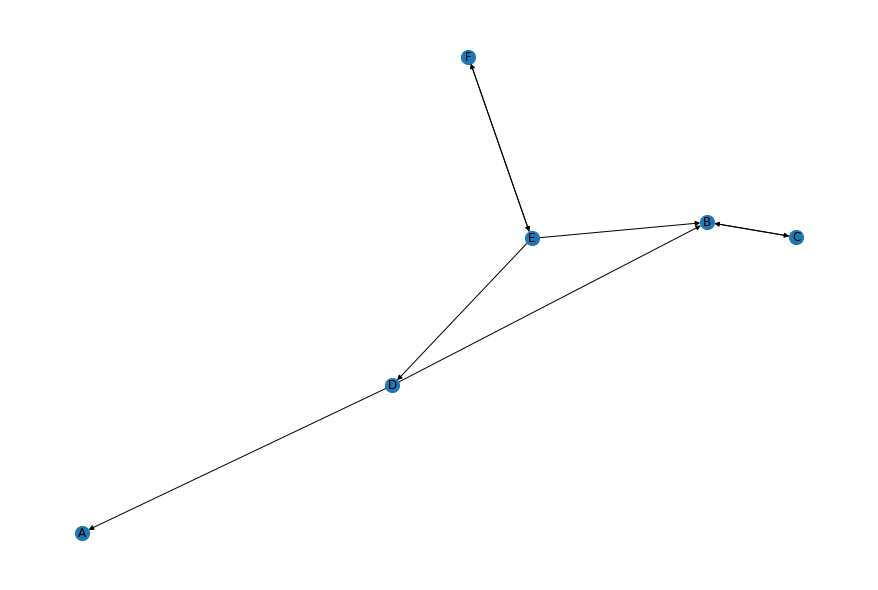

In [382]:
page_rank_graph.plot_graph(node_size=200)

In [310]:
dummy_graph

defaultdict(dict,
            {'B': {'C': 1},
             'C': {'B': 6},
             'D': {'A': 1, 'B': 4},
             'E': {'B': 5, 'D': 2, 'F': 3},
             'F': {'E': 4}})

In [311]:
initial_page_rank_score = {'A' : 1/6, 'B' : 1/6, 'C' : 1/6, 'D' : 1/6, 'E' : 1/6, 'F' : 1/6}

In [318]:
dummy_graph
outlink = {'A': {'D': 1/5},
           'B': {'C': 6/6, 'D': 4/5, 'E': 5/10},
           'C': {'B': 1/1},
           'D': {'E': 2/10},
           'E': {'F': 4/4},
           'F': {'E': 3/10}}

In [324]:
x = {k : v * initial_page_rank_score[k] for k, v in B.items() if k in initial_page_rank_score}

In [330]:
sum(x.values())

0.3833333333333333

In [353]:
N = 6  # number of nodes
lambda_ = .85
page_rank_score_t = {'A' : 1/6, 'B' : 1/6, 'C' : 1/6, 'D' : 1/6, 'E' : 1/6, 'F' : 1/6}
page_rank_score_t_1 = {}
max_iter = 60
i = 0
while i < max_iter:
    i += 1
    print(i)
    for key, value in outlink.items():
        temp = sum({k : v * page_rank_score_t[k] for k, v in outlink[key].items() if k in page_rank_score_t}.values())
        page_rank_score_t_1[key] = ((1-lambda_)/N)  + lambda_*temp
    factor=1/sum(page_rank_score_t_1.values())
    for k in page_rank_score_t_1:
        page_rank_score_t_1[k] = page_rank_score_t_1[k]*factor
        
    diff = np.sqrt(sum((np.array(list(page_rank_score_t.values())) - np.array(list(page_rank_score_t_1.values())))**2))
    
    if diff < 0.001:
        print('Converged')
        break
        
    if i != max_iter:
        page_rank_score_t = page_rank_score_t_1
        page_rank_score_t_1 = {}


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
Converged


In [354]:
page_rank_score_t

{'A': 0.03210119233869339,
 'B': 0.4278498577490391,
 'C': 0.39888024293552077,
 'D': 0.03661928689145861,
 'E': 0.06247113256122751,
 'F': 0.04207828752406076}

In [355]:
page_rank_score_t_1

{'A': 0.032101192338678475,
 'B': 0.42715490748701496,
 'C': 0.39957519319770163,
 'D': 0.03661928689144555,
 'E': 0.06247113256111803,
 'F': 0.04207828752404129}

In [356]:
dummy_graph
outlink = {'A': {'D': 1/5},
           'B': {'C': 6/6, 'D': 4/5, 'E': 5/10},
           'C': {'B': 1/1},
           'D': {'E': 2/10},
           'E': {'F': 4/4},
           'F': {'E': 3/10}}

In [357]:
dummy_graph

defaultdict(dict,
            {'B': {'C': 1},
             'C': {'B': 6},
             'D': {'A': 1, 'B': 4},
             'E': {'B': 5, 'D': 2, 'F': 3},
             'F': {'E': 4}})

In [359]:
# This dictionary represents the probability of  going to a page (key of this dict) from the pages in the values
outlink_dict = defaultdict(dict)
for k, v in dummy_graph.items():
    for i in v:
        try:
            outlink_dict[i][k] = outlink_dict[i][k] + dummy_graph[k][i]/sum(dummy_graph[k].values())
        except:
            outlink_dict[i].update({k: dummy_graph[k][i]/sum(dummy_graph[k].values())})

In [362]:
sorted(outlink_dict)

['A', 'B', 'C', 'D', 'E', 'F']

In [363]:
outlink_dict

defaultdict(dict,
            {'C': {'B': 1.0},
             'B': {'C': 1.0, 'D': 0.8, 'E': 0.5},
             'A': {'D': 0.2},
             'D': {'E': 0.2},
             'F': {'E': 0.3},
             'E': {'F': 1.0}})

In [364]:
{k: 1/N for k, v in outlink.items()}

{'A': 0.16666666666666666,
 'B': 0.16666666666666666,
 'C': 0.16666666666666666,
 'D': 0.16666666666666666,
 'E': 0.16666666666666666,
 'F': 0.16666666666666666}

## Question 4 ~ Logic

In [115]:
Q4_graph = {'source': ['1', '2', '3', '15'], 
           '1': ['4'],
           '2': ['9'],
           '3': ['9'],
           '4': ['5'],
           '5': ['sink'],
           '6': ['7', '8'],
           '7': ['sink'],
           '8': ['sink'],
           '9': ['6'],
           '15': ['9']}

In [116]:
Q4_graph = Graph.from_dict(Q4_graph)

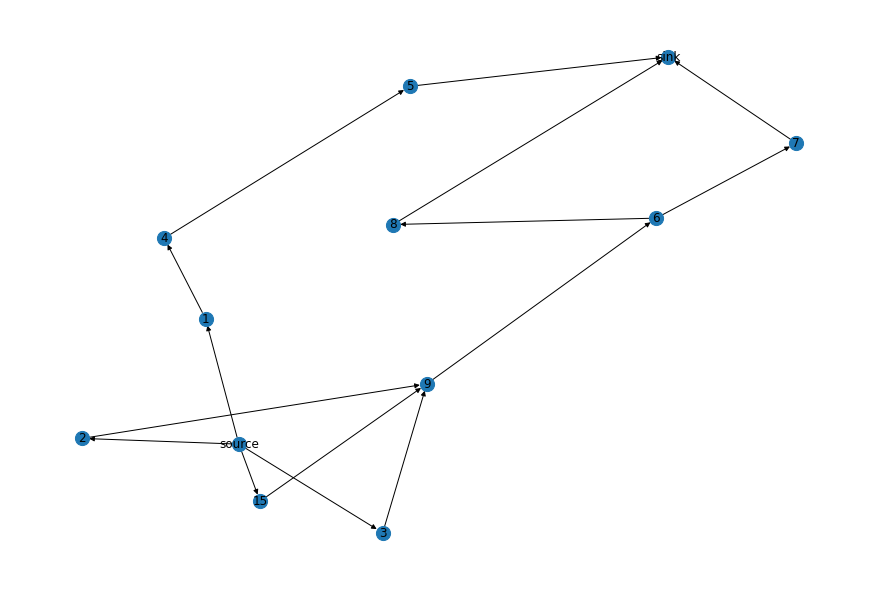

In [117]:
Q4_graph.plot_graph(with_labels=True, node_size=200)

In [122]:
edges_to_cut, min_cut = Q4_graph.max_flow_func('source', 'sink')

Flow: ['source', '1', '4', '5', 'sink']
Flow: ['source', '15', '9', '6', '8', 'sink']


In [120]:
edges_to_cut

['5 --> sink', '8 --> sink']

In [121]:
min_cut

2

In [123]:
edges_to_cut

['9 --> 6', '5 --> sink']